In [1]:
import numpy as np
import pandas as pd
import sys
import re
import operator
sys.path.append("/home/bruce1996/data/Yi-Fung-Chuang/")
from microbiome_preprocessing import split_tax,filter_taxa_by_prevalence,relative_abundance

### Taxonomy profile pre-processing

In [2]:
path = "/home/bruce1996/data/Yi-Fung-Chuang/mock/ont/centri_report/mock.mpa"
ab_table,tax_table = split_tax(path)
otu_table = relative_abundance(ab_table)

tax = list(otu_table.index)
idx = [bool(re.search('s__\S+', x)) for x in tax]
otu_table = otu_table[idx]
tax_table = tax_table[idx]
#remove strain level information
rm_tax = list(otu_table.index)
rm_idx = [bool(re.search('s__\S+s__\S+', x)) for x in rm_tax]
idx = list(map(operator.not_, rm_idx))
otu_table = otu_table[idx]
tax_table = tax_table[idx]
#remove low abundance/prevalence taxa
otu_table,tax_table = filter_taxa_by_prevalence(otu_table,tax_table,1)
idx = otu_table.mean(axis=1) > 10 ** -3
otu_table = otu_table[idx]
tax_table = tax_table[idx]


### 16S quantitative comparison

In [119]:
emu_ground_truth = pd.read_csv('emu_mock_ground_truth.csv')
zymo_ground_truth = pd.read_csv('Zymo_mock_ground_truth.csv')
emu = otu_table.iloc[:,0:2]
zymo = otu_table.iloc[:,2:]

In [120]:
#transform taxonomy name to metaphlan format
emu_idx  = []
for i in emu_ground_truth['Species'] :
    i = i.replace(" ","_") 
    i = 's__' + i
    emu_idx.append(i)
emu_ground_truth.index = emu_idx

zymo_idx= []
for i in zymo_ground_truth['Species'] :
    i = i.replace(" ","_") 
    i = 's__' + i
    zymo_idx.append(i)
zymo_ground_truth.index = zymo_idx

emu_ground_truth.drop('Species', inplace=True, axis=1)
zymo_ground_truth.drop('Species', inplace=True, axis=1)

In [121]:
emu_mock = emu[emu.index.isin(emu_idx)]
emu_fn = list(set(emu_idx) - set(emu_mock.index))
for i in emu_fn :
    emu_mock.loc[i] = [0,0]
emu_mock.loc[:,'Ground_truth'] = emu_ground_truth['Relative_abundance']

zymo_mock = zymo[zymo.index.isin(zymo_idx)]
zymo_fn = list(set(zymo_idx) - set(zymo_mock.index))
for i in zymo_fn :
    zymo_mock.loc[i] = [0,0]
zymo_mock.loc[list(zymo_mock.index),'Ground_truth'] = zymo_ground_truth['Relative_abundance']

In [122]:
emu_other = emu[emu.index.isin(emu_idx) == False]
emu_other = list(emu_other.sum()) + [0]
emu_mock.loc['Others'] = emu_other
emu_mock['Species'] = list(emu_mock.index)
df = emu_mock.melt(id_vars='Species')

zymo_other = zymo[zymo.index.isin(zymo_idx) == False]
zymo_other = list(zymo_other.sum()) + [0]
zymo_mock.loc['Others'] = zymo_other
zymo_mock['Species'] = list(zymo_mock.index)
zymo_df = zymo_mock.melt(id_vars='Species')

/tmp/ipykernel_576563/2013868642.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emu_mock['Species'] = list(emu_mock.index)
/tmp/ipykernel_576563/2013868642.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zymo_mock['Species'] = list(zymo_mock.index)


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

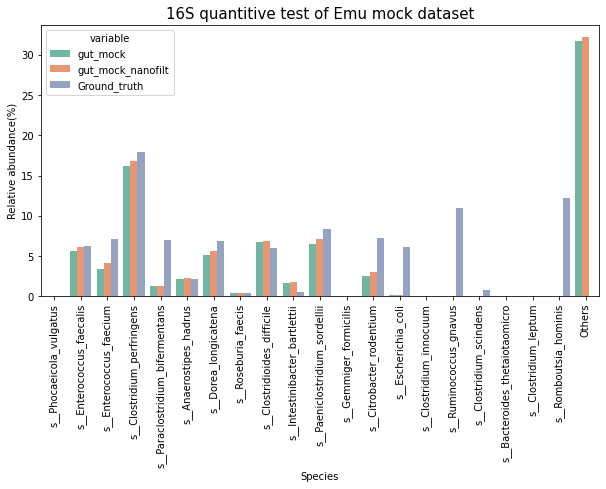

In [9]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x='Species',y='value',hue='variable',data=df,palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_ylabel('Relative abundance(%)')
plt.title('16S quantitive test of Emu mock dataset',fontsize =15)
plt.savefig('tmp/16s_quantitative_test_Emu.png',dpi = 300,bbox_inches = "tight")

### L1 norm

In [143]:
emu_l1 = 0
emu_l1_nano = 0
for i in range(emu_mock.shape[0]) :
    emu_l1 += abs(emu_mock.iloc[i,2] - emu_mock.iloc[i,0])
    emu_l1_nano += abs(emu_mock.iloc[i,2] - emu_mock.iloc[i,1])

zymo_l1 = 0
zymo_l1_nano = 0
for i in range(zymo_mock.shape[0]) :
    zymo_l1 += abs(zymo_mock.iloc[i,2] - zymo_mock.iloc[i,0])
    zymo_l1_nano += abs(zymo_mock.iloc[i,2] - zymo_mock.iloc[i,1])

In [161]:
l1_df = pd.DataFrame({'L1' : [emu_l1,emu_l1_nano,zymo_l1,zymo_l1_nano],
'Dataset' :['Emu','Emu_NanoFilt','ZymoBIOTICS','ZymoBIOTICS_NanoFilt'],
'Quality control' : ['None','NanoFilt','None','NanoFilt']})

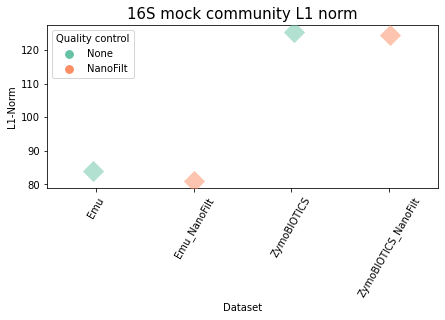

In [165]:
plt.figure(figsize=(7,3))
ax = sns.stripplot(x='Dataset', y='L1',palette="Set2",hue='Quality control',size=15,data=l1_df,marker="D",alpha=.50)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 60)
ax.set_ylabel('L1-Norm')
plt.title('16S mock community L1 norm',fontsize =15)
plt.savefig('tmp/16s_l1.png',dpi = 300,bbox_inches = "tight")